# Technical notebook - data modelling

In [90]:
# Import python modules
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

## Data preparation

In [91]:
# Load data
student_df = pd.read_csv('data/studentInfo.csv')

We have analyzed the new data and seen that all the missing values in the student_info table from Scottish students are now present.<br/>
The only missing values are now in the imd_band column. There are not many of them, so we can just drop them.

In [92]:
student_df.dropna(subset=['imd_band'], inplace=True)
student_df.reset_index(drop=True, inplace=True)

The target variable is the final result.

The "Pass" and "Distinction" values can be grouped together as "Pass".
The "Withdrawn" values do not provide any information, so we can drop them.

In [93]:
# drop Widthdrawn
student_df = student_df[student_df['final_result'] != 'Withdrawn']

In [94]:
# Target variable: final_result
y = student_df[['final_result']]

# convert Pass and Distinction to 1 and Fail to 0
y = y.replace(['Pass', 'Distinction', 'Fail'], [1, 1, 0])

# Features: gender, region, highest education, IMD score, age, number of previous attempts, studied credits and disability
x = student_df[['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability']]

In [95]:
# Verify there are no missing values
print(x.isnull().sum())
print(y.isnull().sum())

gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
dtype: int64
final_result    0
dtype: int64


Next We need to convert the categorical data into numerical data, so we can use it in the models.

In [96]:
le = LabelEncoder()
x['gender'] = le.fit_transform(x['gender'])
x['disability'] = le.fit_transform(x['disability'])
x['imd_band'] = le.fit_transform(x['imd_band'])
x['age_band'] = le.fit_transform(x['age_band'])
x['region'] = le.fit_transform(x['region'])
x['highest_education'] = le.fit_transform(x['highest_education'])

x.head()

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,1,0,1,9,2,0,240,0
1,0,6,1,2,1,0,60,0
3,0,7,0,5,1,0,60,0
4,0,11,2,5,0,0,60,0
5,1,10,0,8,1,0,60,0


Split the data into train and test sets.<br/>
We will use a 80/20 split.

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## 🖼️ Model template

In [136]:
class Model:
    def __init__(self, model, name, x_train, y_train, x_test, y_test):
        self.model = model
        self.name = name

        self.x_train = x_train
        self.y_train = y_train
        self.fit(x_train, y_train)

        self.cross_val_score = self.get_cross_val_score(x_train, y_train)

        self.x_test = x_test
        self.y_test = y_test
        y_pred = self.predict(x_test)

        self.accuracy = self.get_accuracy(y_test, y_pred)
        self.precision = self.get_precision(y_test, y_pred)
        self.recall = self.get_recall(y_test, y_pred)
        self.f1 = self.get_f1(y_test, y_pred)
        self.confusion_matrix = self.get_confusion_matrix(y_test, y_pred)
        self.learning_curve = self.get_learning_curve(x_train, y_train)

    def fit(self, x, y):
        self.model.fit(x, y)

    def predict(self, x):
        return self.model.predict(x)

    def get_model(self):
        return self.model

    def get_accuracy(self, y_true, y_pred):
        self.accuracy = metrics.accuracy_score(y_true, y_pred)
        return self.accuracy

    def get_precision(self,  y_true, y_pred):
        self.precision = metrics.precision_score(y_true, y_pred)
        return self.precision

    def get_recall(self, y_true, y_pred):
        self.recall = metrics.recall_score(y_true, y_pred)
        return self.recall

    def get_f1(self, y_true, y_pred):
        self.f1 = metrics.f1_score(y_true, y_pred)
        return self.f1

    def get_cross_val_score(self, x, y, cv=10):
        self.cross_val_score = cross_val_score(self.model, x, y, cv=cv)
        return self.cross_val_score

    def get_confusion_matrix(self, y_true, y_pred):
        self.confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        return self.confusion_matrix

    def get_learning_curve(self, x, y, cv=10):
        self.learning_curve = learning_curve(self.model, x, y, cv=cv)
        return self.learning_curve

    def print_cross_val_score(self):
        print('Cross Validation Score: ')
        for i in range(len(self.cross_val_score)):
            print('Fold ', i+1, ': ', round(self.cross_val_score[i], 4))

    def print_metrics(self):
        print('Metrics for ', self.name)
        print('Accuracy: ', round(self.accuracy, 4))
        print('Precision: ', round(self.precision, 4))
        print('Recall: ', round(self.recall, 4))
        print('F1: ', round(self.f1, 4))

    def plot_confusion_matrix(self):
        cm = self.confusion_matrix
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Fail'])
        disp.plot()
        plt.show()

    def plot_learning_curve(self):
        train_sizes, train_scores, test_scores = self.learning_curve
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.title(self.name + " Learning Curve")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.show()

## 📝 Models

### Decision Tree

In [137]:
decision_tree = Model(tree.DecisionTreeClassifier(max_depth=5), 'Decision Tree Classifier', x_train, y_train, x_test, y_test)

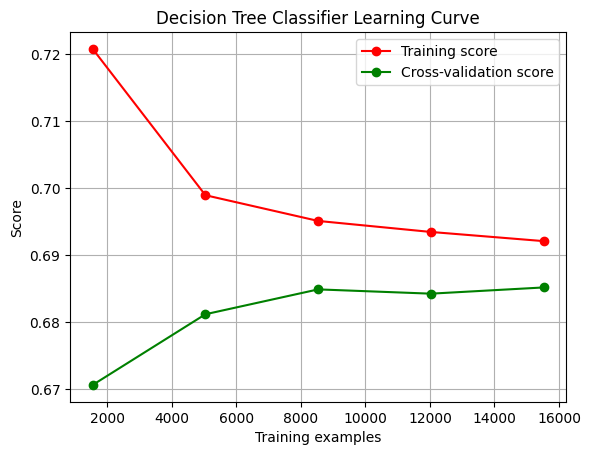

In [133]:
decision_tree.plot_learning_curve()

In [138]:
decision_tree.print_metrics()

Metrics for  Decision Tree Classifier
Accuracy:  0.6793
Precision:  0.7187
Recall:  0.8769
F1:  0.79


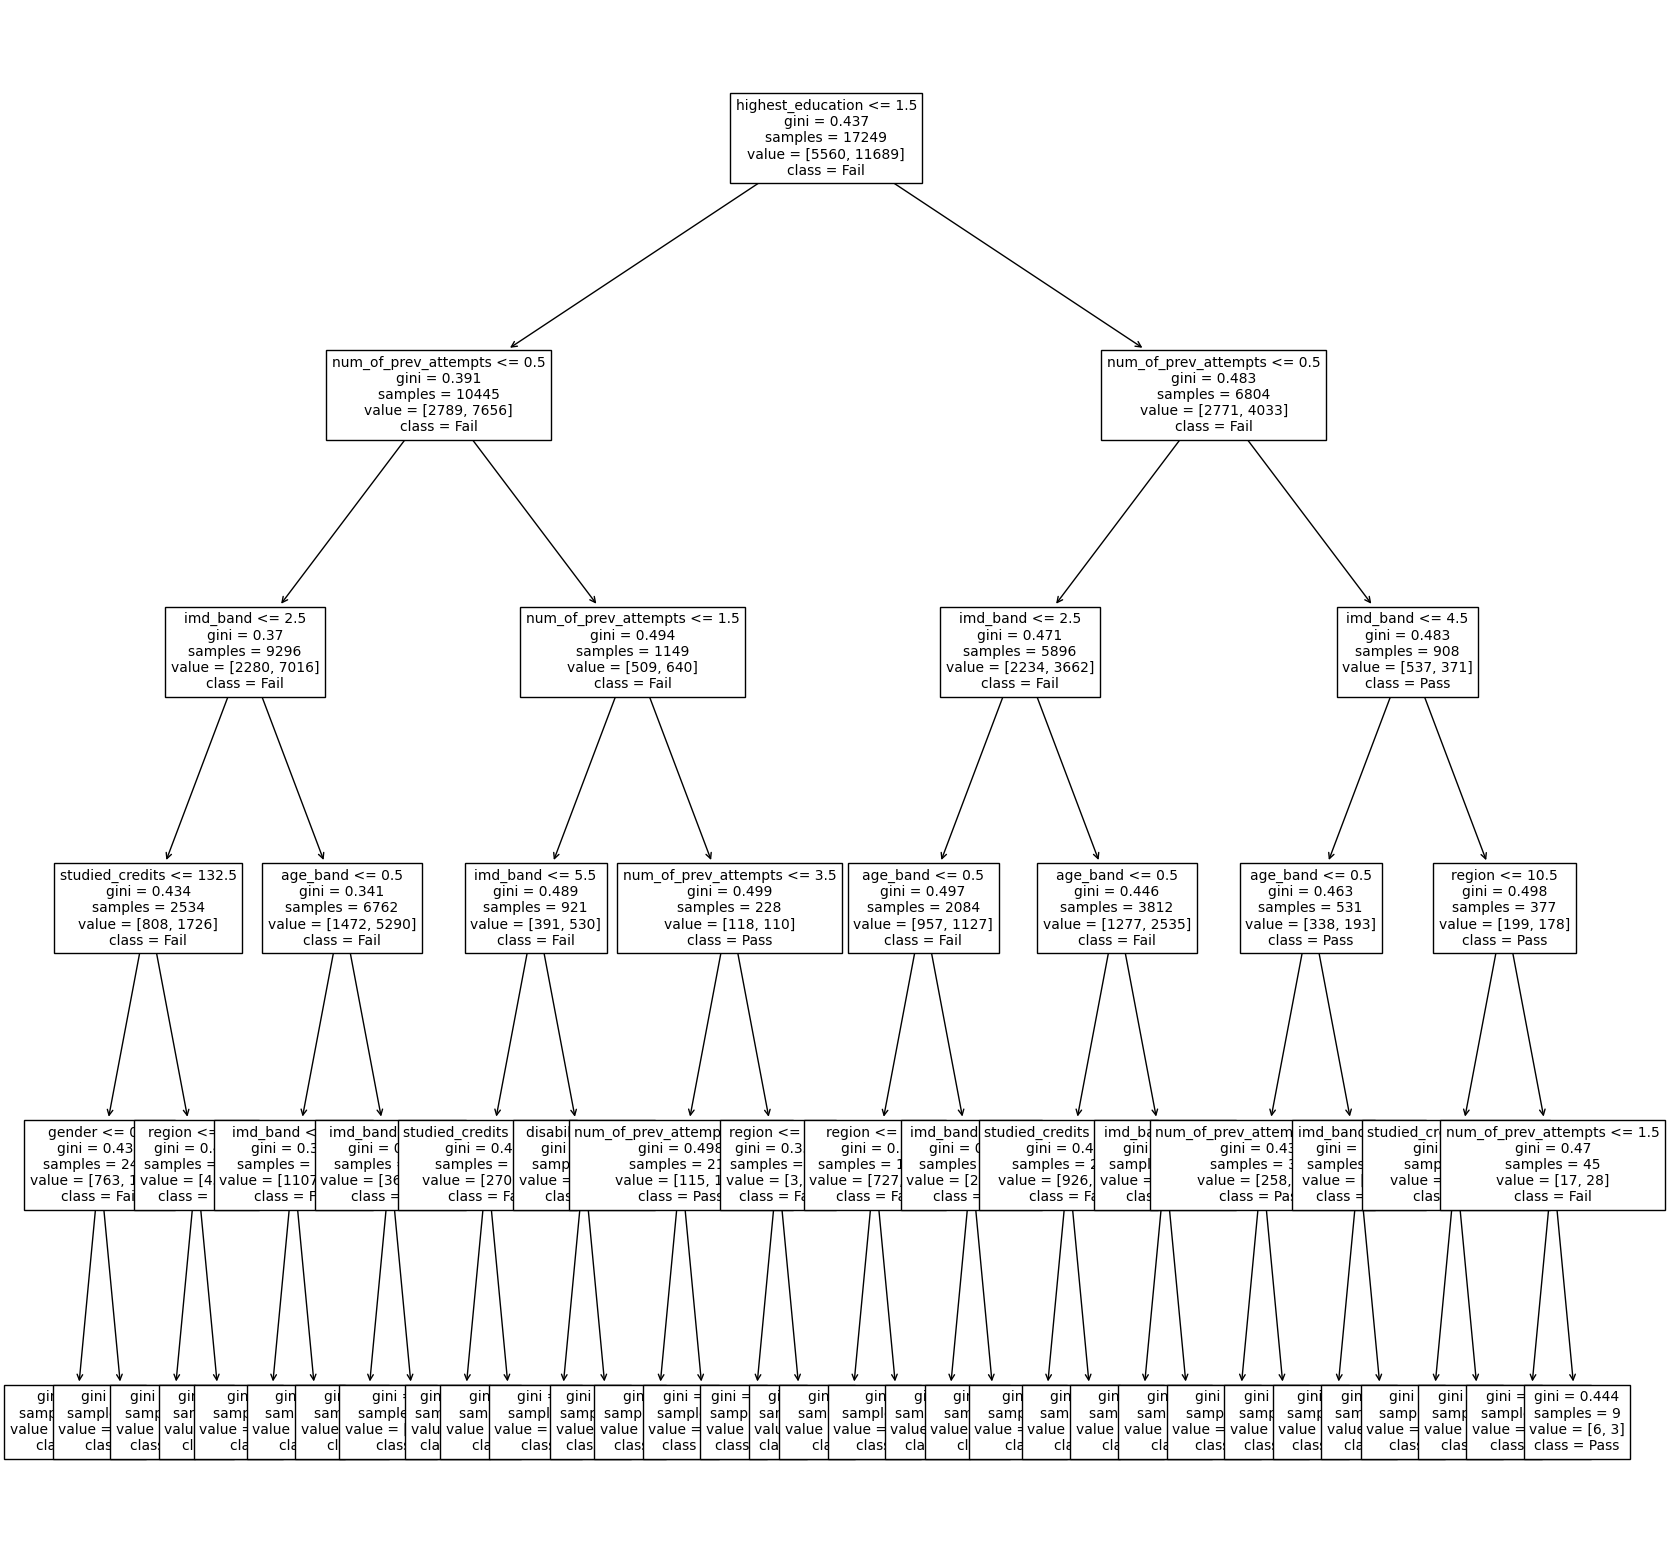

In [140]:
# plot decision tree
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(decision_tree.get_model(), ax=ax, fontsize=10, feature_names=x.columns, class_names=['Pass', 'Fail'])
plt.show()

In [ ]:

#plot confusion matrix
plot_confusion_matrix(clf, y_test, y_pred)

# print accuracy, recall, precision and f1 score
print_metrics(y_test, y_pred, clf.classes_)



In [18]:
# use bournoulli naive bayes to predict the final result
from sklearn.naive_bayes import BernoulliNB


clf = BernoulliNB()
# Turn y_train into a 1d array

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Cross validation
print(cross_val_score(clf, x_train, y_train))


print("Accuracy naive bayes:", metrics.accuracy_score(y_test, y_pred))
print("Recall decision tree:", metrics.recall_score(y_test, y_pred))
print("Precision decision tree:", metrics.precision_score(y_test, y_pred))
print("F1 score decision tree:", metrics.f1_score(y_test, y_pred))

[0.6881762  0.68006182 0.68612292 0.69308079 0.68882876]
Accuracy naive bayes: 0.6839420289855073
Recall decision tree: 0.11026478055857816
Precision decision tree: 0.5268630849220104
F1 score decision tree: 0.18236352729454108


c:\Users\Cristina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Cristina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Cristina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Cristina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py

In [230]:
# use random forest classifier to predict the final result
clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0)
y_train = np.ravel(y_train)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
cross_val_score(clf, x_train, y_train)

array([0.69319938, 0.68044822, 0.68380363, 0.68921531, 0.68882876])

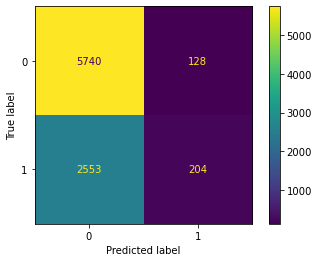

[learning_curve] Training set sizes: [  103   312   521   730   939  1148  1358  1567  1776  1985  2194  2403
  2612  2821  3030  3239  3448  3658  3867  4076  4285  4494  4703  4912
  5121  5330  5539  5748  5958  6167  6376  6585  6794  7003  7212  7421
  7630  7839  8048  8258  8467  8676  8885  9094  9303  9512  9721  9930
 10139 10349]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.9min finished
/Users/gregreynders/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


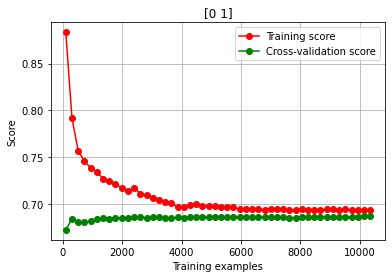

Accuracy [0 1]: 0.6891594202898551
Recall [0 1]: 0.07399347116430903
Precision [0 1]: 0.6144578313253012
F1 score [0 1]: 0.1320815797992878


In [231]:
plot_confusion_matrix(clf, y_test, y_pred)
plot_learning_curve(clf, clf.classes_, x_train, y_train)
print_metrics(y_test, y_pred, clf.classes_)

In [232]:
# use logistic regression to predict the final result
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500).fit(x_train, y_train)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
cross_val_score(clf, x_train, y_train)

array([0.69513138, 0.68160742, 0.67916506, 0.69346734, 0.68921531])

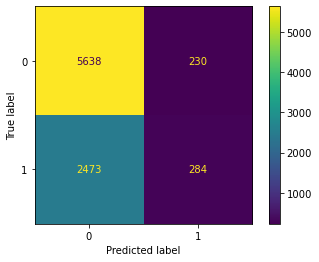

[learning_curve] Training set sizes: [  103   312   521   730   939  1148  1358  1567  1776  1985  2194  2403
  2612  2821  3030  3239  3448  3658  3867  4076  4285  4494  4703  4912
  5121  5330  5539  5748  5958  6167  6376  6585  6794  7003  7212  7421
  7630  7839  8048  8258  8467  8676  8885  9094  9303  9512  9721  9930
 10139 10349]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   12.0s finished
/Users/gregreynders/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


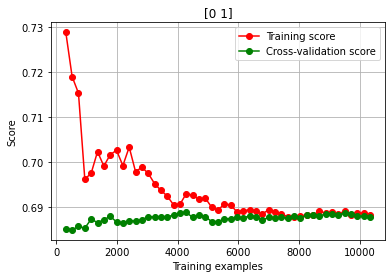

Accuracy [0 1]: 0.6866086956521739
Recall [0 1]: 0.10301051867972434
Precision [0 1]: 0.5525291828793775
F1 score [0 1]: 0.17364720269030878


In [233]:

plot_confusion_matrix(clf, y_test, y_pred)
plot_learning_curve(clf, clf.classes_, x_train, y_train)
print_metrics(y_test, y_pred, clf.classes_)

In [234]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(x_train, y_train)
y_pred = knn_classifier.predict(x_test)
cross_val_score(clf, x_train, y_train)

array([0.69513138, 0.68160742, 0.67916506, 0.69346734, 0.68921531])

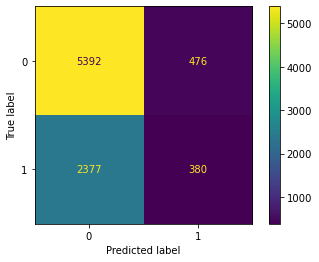

[learning_curve] Training set sizes: [  103   312   521   730   939  1148  1358  1567  1776  1985  2194  2403
  2612  2821  3030  3239  3448  3658  3867  4076  4285  4494  4703  4912
  5121  5330  5539  5748  5958  6167  6376  6585  6794  7003  7212  7421
  7630  7839  8048  8258  8467  8676  8885  9094  9303  9512  9721  9930
 10139 10349]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   41.5s finished
/Users/gregreynders/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


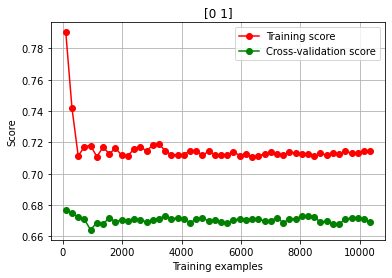

Accuracy [0 1]: 0.6692173913043479
Recall [0 1]: 0.1378309756982227
Precision [0 1]: 0.4439252336448598
F1 score [0 1]: 0.21035150844173817


In [235]:
plot_confusion_matrix(knn_classifier, y_test, y_pred)
plot_learning_curve(clf, clf.classes_, x_train, y_train)
print_metrics(y_test, y_pred, knn_classifier.classes_)

In [236]:
# use naive bayes to predict the final result
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
cross_val_score(clf, x_train, y_train)

array([0.67542504, 0.65455951, 0.67375338, 0.68534983, 0.67182064])

[learning_curve] Training set sizes: [  103   312   521   730   939  1148  1358  1567  1776  1985  2194  2403
  2612  2821  3030  3239  3448  3658  3867  4076  4285  4494  4703  4912
  5121  5330  5539  5748  5958  6167  6376  6585  6794  7003  7212  7421
  7630  7839  8048  8258  8467  8676  8885  9094  9303  9512  9721  9930
 10139 10349]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.9s finished
/Users/gregreynders/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


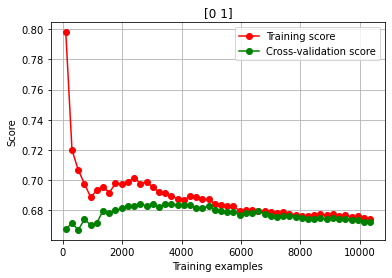

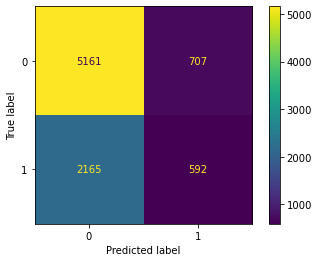

Accuracy [0 1]: 0.6670144927536232
Recall [0 1]: 0.21472615161407327
Precision [0 1]: 0.45573518090839105
F1 score [0 1]: 0.29191321499013806


In [237]:
plot_learning_curve(clf, clf.classes_, x_train, y_train)
plot_confusion_matrix(clf, y_test, y_pred)
print_metrics(y_test, y_pred, clf.classes_)

In [238]:
y_train = np.ravel(y_train)
clf = SVC(kernel='linear')
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [241]:
plot_learning_curve(clf, clf.classes_, x_train, y_train)
plot_confusion_matrix(clf, y_test, y_pred)
print_metrics(y_test, y_pred, clf.classes_)

[learning_curve] Training set sizes: [  103   312   521   730   939  1148  1358  1567  1776  1985  2194  2403
  2612  2821  3030  3239  3448  3658  3867  4076  4285  4494  4703  4912
  5121  5330  5539  5748  5958  6167  6376  6585  6794  7003  7212  7421
  7630  7839  8048  8258  8467  8676  8885  9094  9303  9512  9721  9930
 10139 10349]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
y_train = np.ravel(y_train)
clf = SVC(kernel='rbf')
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

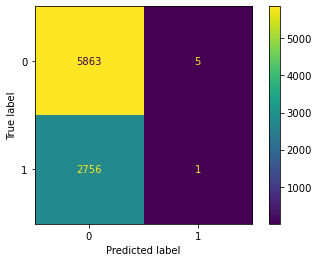

Accuracy SVC rbf: 0.6798840579710145
Recall SVC rbf: 0.0003627130939426913
Precision SVC rbf: 0.16666666666666666
F1 score SVC rbf: 0.0007238508867173361


In [ ]:
plot_learning_curve(clf, clf.classes_, x_train, y_train)
plot_confusion_matrix(clf, y_test, y_pred)
print_metrics(y_test, y_pred, "SVC rbf")


In [ ]:
y_train = np.ravel(y_train)
clf = SVC(kernel='poly')
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)


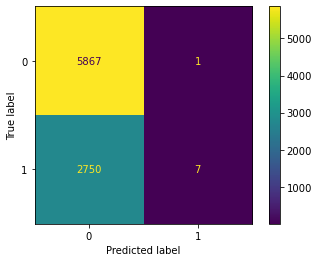

Accuracy SVC poly: 0.6810434782608695
Recall SVC poly: 0.0025389916575988395
Precision SVC poly: 0.875
F1 score SVC poly: 0.005063291139240506


In [ ]:
plot_learning_curve(clf, clf.classes_, x_train, y_train)
plot_confusion_matrix(clf, y_test, y_pred)
print_metrics(y_test, y_pred, "SVC poly")

In [ ]:
y_train = np.ravel(y_train)
clf = SVC(kernel='sigmoid')
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

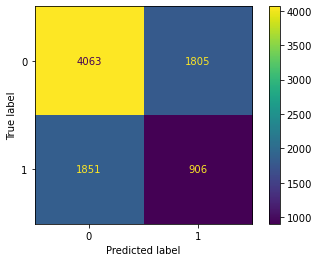

Accuracy sigmoid: 0.5761159420289855
Recall sigmoid: 0.32861806311207836
Precision sigmoid: 0.3341940243452601
F1 score sigmoid: 0.3313825896122897


In [ ]:
plot_learning_curve(clf, clf.classes_, x_train, y_train)
plot_confusion_matrix(clf, y_test, y_pred)
print_metrics(y_test, y_pred, "sigmoid")

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=x_train.shape[1], activation='relu',kernel_initializer='lecun_uniform'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu', kernel_initializer='lecun_uniform'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# Use cross_val_score to evaluate the model using 10-fold cross-validation
scores = cross_val_score(model, x_train, y_train, cv=10)

# Print the mean and standard deviation of the scores
print("Mean accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

# Train the model, keeping track of the training and validation accuracy for each epoch
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test))

# Extract the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation recall
plt.plot(range(1, len(train_acc) + 1), train_acc, 'b', label='Training accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# make confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
predictions = model.predict(x_test)
 # print the predictions
print(predictions)

/var/folders/37/z4jydb4976915t7k69vbvb4c0000gn/T/ipykernel_45343/1435014441.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)


KeyboardInterrupt: 

In [ ]:
# Create a confusion matrix
confusion_mat = confusion_matrix(y_test, predictions)
print(confusion_mat)

# print the accuracy
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

# print the precision
print("Precision:",metrics.precision_score(y_test, predictions))

# print the recall
print("Recall:",metrics.recall_score(y_test, predictions))

# print the f1 score
print("F1 Score:",metrics.f1_score(y_test, predictions))

[[5306  562]
 [2177  580]]
Accuracy: 0.6824347826086956
Precision: 0.5078809106830122
Recall: 0.21037359448676096
F1 Score: 0.2975121826109259
